<a href="https://colab.research.google.com/github/LMAPcoder/Distributed-Data-Analytics-Lab/blob/main/DDA_sheet9_cnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab Distributed Data Analytics**

## Tutorial 9

### 1. Image Classification

In [ ]:
#Downloading file
!wget --no-check-certificate 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz' -O flower_photos.tgz

--2023-06-30 18:40:49--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 142.251.167.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   128MB/s    in 1.7s    

2023-06-30 18:40:51 (128 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
#untarring the file
!sudo tar -xzf flower_photos.tgz
!rm flower_photos.tgz #to remove the tar file

Data exploration

In [ ]:
import os
from PIL import Image
import pandas as pd
import numpy as np

roses


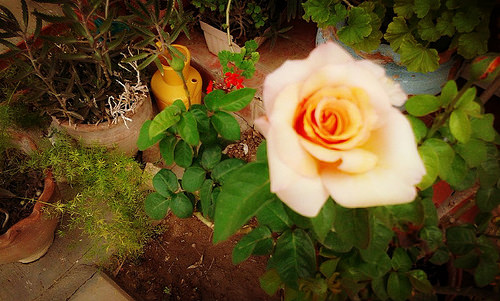

dandelion


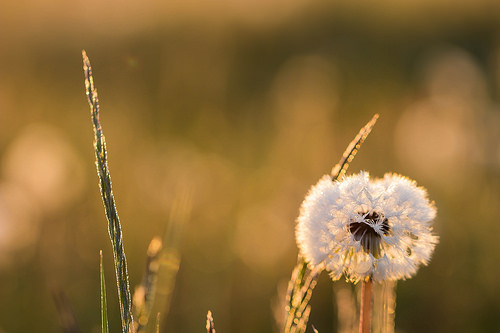

tulips


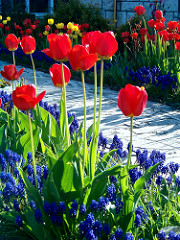

daisy


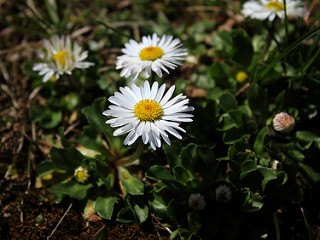

sunflowers


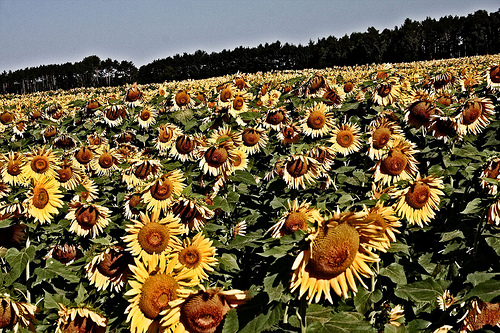

In [ ]:
#Printing an example from each class
folder_path = 'flower_photos'
image_dict = dict()

for subfolder in os.listdir(folder_path):
  subfolder_path = os.path.join(folder_path, subfolder)
  if os.path.isdir(subfolder_path):
    image_sizes = list()
    for image_name in os.listdir(subfolder_path):
      image_path = os.path.join(subfolder_path, image_name)
      image = Image.open(image_path)
      image_sizes.append(image.size)

    image_dict[subfolder] = image_sizes
    print(subfolder)
    image.show()
      # break

In [ ]:
df = pd.DataFrame(image_dict.items(), columns=['subfolder', 'tuples'])
df = df.explode('tuples').reset_index(drop=True)

In [ ]:
#Number of images per class and per size
sizes_summary = df.groupby(by=['subfolder','tuples']).value_counts().reset_index()
sizes_summary

,subfolder,tuples,0
0,daisy,"(158, 240)",2
1,daisy,"(159, 240)",11
2,daisy,"(160, 240)",2
3,daisy,"(163, 240)",1
4,daisy,"(170, 240)",1
...,...,...,...
788,tulips,"(640, 232)",1
789,tulips,"(640, 236)",1
790,tulips,"(640, 276)",1
791,tulips,"(1024, 187)",1


There are significant variety of image sizes in the dataset

In [ ]:
#Number of images per class
sizes_totals = sizes_summary.groupby(by=['subfolder'])[0].sum().reset_index()
sizes_totals

,subfolder,0
0,daisy,633
1,dandelion,898
2,roses,641
3,sunflowers,699
4,tulips,799


The dataset is more or less balanced

In [ ]:
#Total number of images in the dataset
sizes_totals[0].sum()

3670

DataLoader

ImageFolder is a class provided by the torchvision.datasets module that allows you to conveniently load images from a directory structure where each subdirectory represents a different class or category.

The DataLoader class in PyTorch provides an efficient way to load and pass data to the model during the training process. It takes care of dividing the dataset into batches, shuffling the data if specified, and loading the data in parallel using multiple worker processes.

DataLoader loads the data on-the-fly, which means it fetches a batch of data from the dataset as it is needed during training. This approach is memory-efficient because the entire dataset does not need to be loaded into memory at once.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
import matplotlib.pyplot as plt
import time

In [ ]:
#Transformation to apply while generating the data
train_transforms = transforms.Compose([
    transforms.Resize (size =(180 , 180)),
    transforms.ToTensor() ,])

#Getting data from folder
data = ImageFolder(root="flower_photos", transform=train_transforms)

#We split the train dataset into a train and test dataset
split_ratio = 0.8
N = len(data)
N_train = int(N*split_ratio)
train_ds, test_ds = torch.utils.data.random_split(data, [N_train, N-N_train])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In PyTorch, the convention for representing images is (channels, height, width),

In [ ]:
for images, labels in train_loader:
  print('Image size:', images[0].size())
  print('Label:', labels[0])

  break

Image size: torch.Size([3, 180, 180])
Label: tensor(0)
torch.Size([180, 180, 3])


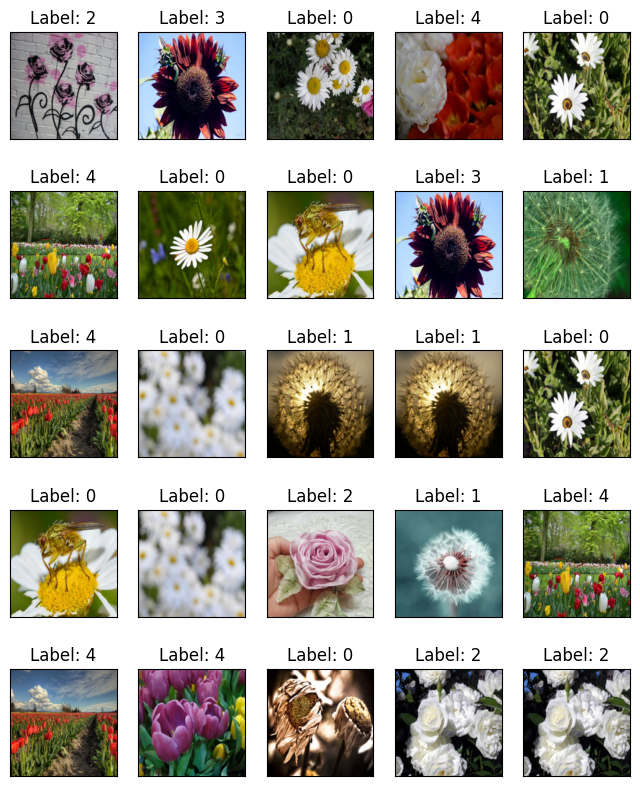

In [ ]:
#Printing a random subset of training dataset along with the labels
for images, labels in train_loader:
  fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))
  for i in range(5):
    for j in range(5):
      idx = np.random.randint(images.shape[0])
      ax[i,j].set_title(f'Label: {labels[idx]}')
      ax[i,j].imshow(images[idx].permute(1, 2, 0))
      ax[i,j].axes.yaxis.set_visible(False)
      ax[i,j].axes.xaxis.set_visible(False)
  break

In [ ]:
#Check for availability of GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    name = torch.cuda.get_device_name(0)
    print(f'GPU {name} is available!')
else:
    device = torch.device('cpu')
    print('GPU is not available, using CPU instead.')

GPU Tesla T4 is available!


In [ ]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl, test_dl, device='cpu'):

    model.train() #setup model for training. Some types of layers, like batch normalization or dropout, behave differently
    loss_curve = list()
    start_time = time.time() #starting time of the training algorithm

    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        start_time_epoch = time.time() #starting time of the epoch

        # Train with batches of data
        for xb, yb in train_dl:

            xb = xb.to(device)
            yb = yb.to(device)

            # 1. Generate predictions
            Y_hat = model(xb)

            # 2. Calculate loss
            loss = loss_fn(Y_hat, yb)

            # 3. Compute gradients
            loss.backward()

            # 4. Update parameters using gradients
            opt.step()

            # 5. Reset the gradients to zero
            opt.zero_grad()

            #Save loss function values

        loss_curve.append(loss.detach())

        #Computing accuracy on train and test datasets
        train_acc = accuracy(model, train_dl, device)
        test_acc = accuracy(model, test_dl, device)

        end_time_epoch = time.time() #end time of the epoch
        elapsed_time = end_time_epoch - start_time_epoch

        if epoch%5 == 0:
            print(f'Epoch: {epoch}, time_epoch: {elapsed_time:.2f}, training_loss: {loss.detach():.2f}, training_accuracy: {train_acc:.2f}, test_accuracy: {test_acc:.2f}')

    return loss_curve

def accuracy(model, data_loader, device='cpu'):

    correct_pred = 0
    n = 0

    model.eval() #setup model for evaluation

    with torch.no_grad():

        for X, y in data_loader:

            X = X.to(device)
            y = y.to(device)

            y_logits = model(X)
            _, y_hat = torch.max(y_logits, 1) #valid for multiclass problem

            n += y.size(0)
            correct_pred += (y_hat == y).sum().item()

    return correct_pred / n


Version 1

In [ ]:
num_classes = 5

num_epochs = 30 #maximum number of ephocs
lr = 0.01 #learning rate

#Defining model version 1
model = torch.nn.Sequential(

    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0),
    torch.nn.ReLU(inplace=True),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=22*22*64, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512, out_features=num_classes),
    torch.nn.ReLU()

  ).to(device)

loss = torch.nn.CrossEntropyLoss() #cross entropy loss between input logits and target
opt = torch.optim.SGD(
    model.parameters(),
    lr=lr, #learning rate
    momentum=0 #momentum factor
    )

In [ ]:
from torchsummary import summary
summary(model,(3,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 180, 180]             448
              ReLU-2         [-1, 16, 180, 180]               0
         MaxPool2d-3           [-1, 16, 90, 90]               0
            Conv2d-4           [-1, 32, 90, 90]           4,640
              ReLU-5           [-1, 32, 90, 90]               0
         MaxPool2d-6           [-1, 32, 45, 45]               0
            Conv2d-7           [-1, 64, 22, 22]          18,496
              ReLU-8           [-1, 64, 22, 22]               0
           Flatten-9                [-1, 30976]               0
           Linear-10                  [-1, 512]      15,860,224
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 5]           2,565
             ReLU-13                    [-1, 5]               0
Total params: 15,886,373
Trainable para

In [ ]:
%%time
loss_curve = fit(num_epochs, model, loss, opt, train_loader, test_loader, device)

Epoch: 0,	 time_epoch: 37.78,	 training_loss: 1.61,	 training_accuracy: 0.26,	 test_accuracy: 0.24
Epoch: 5,	 time_epoch: 29.74,	 training_loss: 1.20,	 training_accuracy: 0.48,	 test_accuracy: 0.53
Epoch: 10,	 time_epoch: 30.27,	 training_loss: 1.21,	 training_accuracy: 0.57,	 test_accuracy: 0.56
Epoch: 15,	 time_epoch: 33.42,	 training_loss: 1.28,	 training_accuracy: 0.58,	 test_accuracy: 0.55
Epoch: 20,	 time_epoch: 29.37,	 training_loss: 0.97,	 training_accuracy: 0.67,	 test_accuracy: 0.58
Epoch: 25,	 time_epoch: 29.44,	 training_loss: 0.84,	 training_accuracy: 0.73,	 test_accuracy: 0.58
CPU times: user 14min 46s, sys: 10.1 s, total: 14min 56s
Wall time: 15min 8s


Given the low value at what test accuracy got stuck, we can infer that the model suffer from overfitting

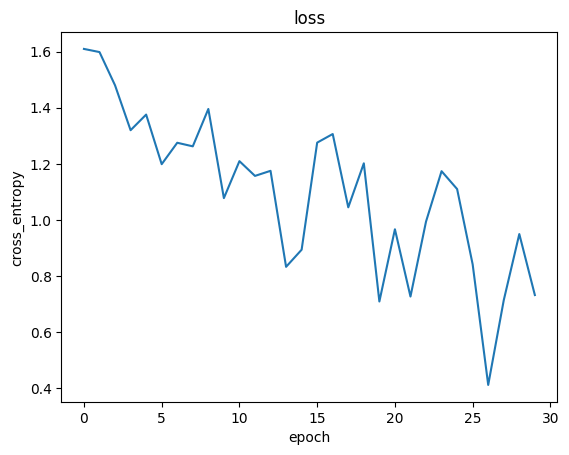

In [ ]:
loss_curve = [tensor.item() for tensor in loss_curve]
plt.plot(loss_curve)
plt.xlabel('epoch')
plt.ylabel('cross_entropy')
plt.title('loss')
plt.show()

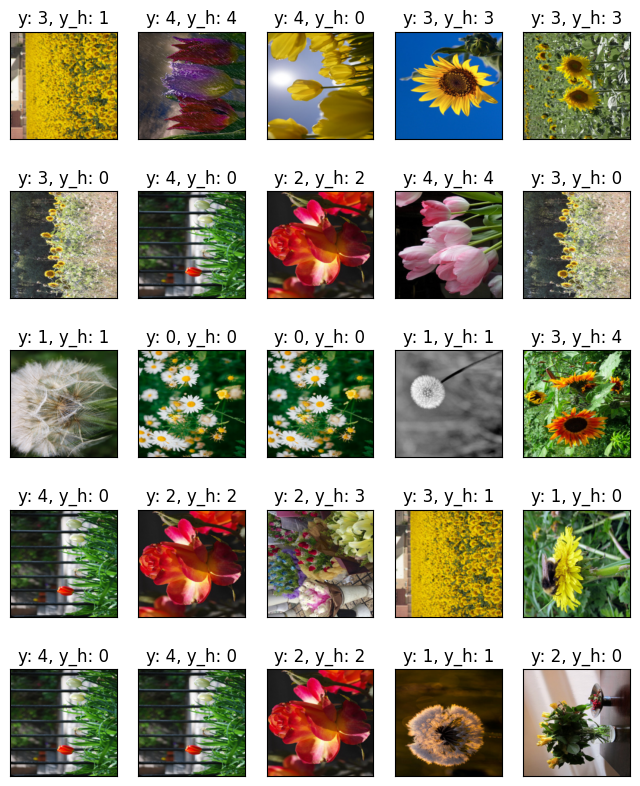

In [ ]:
for images, labels in test_loader:
  model.cpu()
  y_logits = model(images)
  _, y_hat = torch.max(y_logits, 1)

  fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))
  for i in range(5):
    for j in range(5):
      idx = np.random.randint(images.shape[0])
      ax[i,j].set_title(f'y: {labels[idx]}, y_h: {y_hat[idx]}')
      ax[i,j].imshow(images[idx].permute(1, 2, 0))
      ax[i,j].axes.yaxis.set_visible(False)
      ax[i,j].axes.xaxis.set_visible(False)
  break

2 The "Easy" Way

In [ ]:
import psutil

# Get the system memory information
mem = psutil.virtual_memory()

# Print the total RAM usage
total_ram_usage = mem.total - mem.available
ram_usage_readable = psutil._common.bytes2human(total_ram_usage)

print(f"RAM Usage: {ram_usage_readable}")

RAM Usage: 4.4G


Moving images to the RAM

In [ ]:
%%time

data_loader = DataLoader(data, batch_size=1, shuffle=False)

predictors = list()
labels = list()

# Iterate over the dataset and collect the samples
for batch in data_loader:
    x, y = batch
    predictors.append(x)
    labels.append(y)

# Concatenate the samples into a single tensor
predictors = torch.cat(predictors, dim=0)
labels = torch.cat(labels, dim=0)

mem = psutil.virtual_memory()
total_ram_usage = mem.total - mem.available
ram_usage_readable = psutil._common.bytes2human(total_ram_usage)
print(f"RAM Usage: {ram_usage_readable}")

RAM Usage: 8.0G
CPU times: user 15.9 s, sys: 1.75 s, total: 17.7 s
Wall time: 18.4 s


We can see that the RAM usage increased in almost 4 Gigabytes

In [ ]:
#Size of the input tensor
predictors.size()

torch.Size([3670, 3, 180, 180])

In [ ]:
dataset = TensorDataset(predictors, labels)
del predictors
del labels

split_ratio = 0.8
N = len(data)
N_train = int(N*split_ratio)
train_ds, test_ds = torch.utils.data.random_split(dataset, [N_train, N-N_train])
del dataset
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
del train_ds
del test_ds

In [ ]:
%%time
model.cuda()
loss_curve = fit(num_epochs, model, loss, opt, train_loader, test_loader, device)

Epoch: 0,	 time_epoch: 2.86,	 training_loss: 1.61,	 training_accuracy: 0.17,	 test_accuracy: 0.17
Epoch: 5,	 time_epoch: 2.49,	 training_loss: 1.61,	 training_accuracy: 0.26,	 test_accuracy: 0.25
Epoch: 10,	 time_epoch: 2.50,	 training_loss: 1.39,	 training_accuracy: 0.32,	 test_accuracy: 0.35
Epoch: 15,	 time_epoch: 2.48,	 training_loss: 1.37,	 training_accuracy: 0.40,	 test_accuracy: 0.38
Epoch: 20,	 time_epoch: 2.47,	 training_loss: 1.18,	 training_accuracy: 0.44,	 test_accuracy: 0.41
Epoch: 25,	 time_epoch: 2.46,	 training_loss: 1.11,	 training_accuracy: 0.55,	 test_accuracy: 0.52
CPU times: user 1min 13s, sys: 300 ms, total: 1min 14s
Wall time: 1min 15s


As we can see from the training logs, to load all the data in RAM significally speeds up the training process

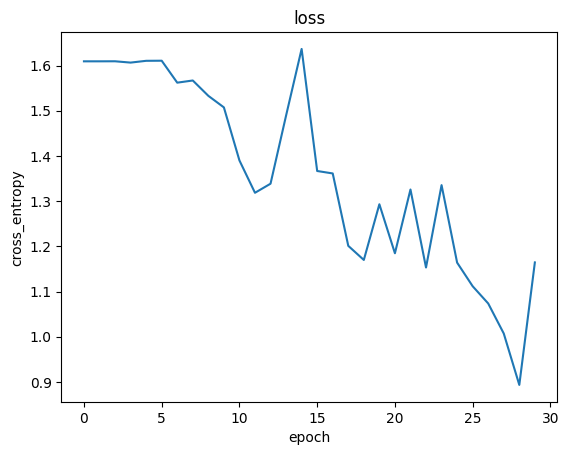

In [ ]:
loss_curve = [tensor.item() for tensor in loss_curve]
plt.plot(loss_curve)
plt.xlabel('epoch')
plt.ylabel('cross_entropy')
plt.title('loss')
plt.show()

Version 2

In [ ]:
#Defining model version 2
model = torch.nn.Sequential(

    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=3, stride=3),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=3, stride=3),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=20*20*32, out_features=512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=512, out_features=num_classes),
    torch.nn.ReLU(inplace=True)

  ).to(device)

loss = torch.nn.CrossEntropyLoss() #cross entropy loss between input logits and target
opt = torch.optim.SGD(
    model.parameters(),
    lr=lr, #learning rate
    momentum=0.1 #momentum factor
    )

In [ ]:
from torchsummary import summary
summary(model,(3,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 180, 180]             448
              ReLU-2         [-1, 16, 180, 180]               0
         MaxPool2d-3           [-1, 16, 60, 60]               0
            Conv2d-4           [-1, 32, 60, 60]           4,640
              ReLU-5           [-1, 32, 60, 60]               0
         MaxPool2d-6           [-1, 32, 20, 20]               0
           Flatten-7                [-1, 12800]               0
            Linear-8                  [-1, 512]       6,554,112
              ReLU-9                  [-1, 512]               0
           Linear-10                    [-1, 5]           2,565
             ReLU-11                    [-1, 5]               0
Total params: 6,561,765
Trainable params: 6,561,765
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forw

This model has 6.5M parameters, and it is half the size of the version 1 (15.8M)

In [ ]:
%%time
loss_curve = fit(num_epochs, model, loss, opt, train_loader, test_loader, device)

Epoch: 0,	 time_epoch: 2.11,	 training_loss: 1.58,	 training_accuracy: 0.35,	 test_accuracy: 0.34
Epoch: 5,	 time_epoch: 1.97,	 training_loss: 1.43,	 training_accuracy: 0.54,	 test_accuracy: 0.52
Epoch: 10,	 time_epoch: 1.96,	 training_loss: 1.05,	 training_accuracy: 0.60,	 test_accuracy: 0.51
Epoch: 15,	 time_epoch: 1.98,	 training_loss: 1.14,	 training_accuracy: 0.67,	 test_accuracy: 0.61
Epoch: 20,	 time_epoch: 1.94,	 training_loss: 0.70,	 training_accuracy: 0.74,	 test_accuracy: 0.63
Epoch: 25,	 time_epoch: 2.07,	 training_loss: 0.89,	 training_accuracy: 0.80,	 test_accuracy: 0.64
CPU times: user 59 s, sys: 267 ms, total: 59.3 s
Wall time: 59.9 s


We can see that given that this model is smaller, the time per epoch is lower. Moreover, we have reached the top test accuracy (around 60%) with fewer epochs.

We should implement some regularization techniques to address the overfitting problem.